# Rolling windows and differences

In this part, we will look at the evolution of time series from two other perspectives.

In [1]:
# Necessary import evil

import pandas as pd
import matplotlib.pyplot as plt
from pandas import IndexSlice as idx
import pandera as pa
from pandera import DataFrameModel
from pandera.typing import DataFrame

from weatherlyser.loader import load_chmi_data

In [2]:
data = pd.read_parquet("../data/open_meteo_2000-2022.pq")

# Most meteorological reporting is done in local time
data = data.tz_convert(level="time", tz="Europe/Prague")

best_model_data = data.loc[idx[:, "best_match"], :].reset_index("model", drop=True)

## Rolling windows

When you are not interested in a fixed window in time (such as "every June"), but rather in a moving interval ending (or being centered) around each point in the time series, you should use the `rolling` method:

In [3]:
best_model_data.rolling("1D")

Rolling [window=1D,min_periods=1,center=False,axis=0,method=single]

As you are already familiar with, this is just the "grouping" object, not any computation result. However, we can do operations on it!

<Axes: xlabel='time'>

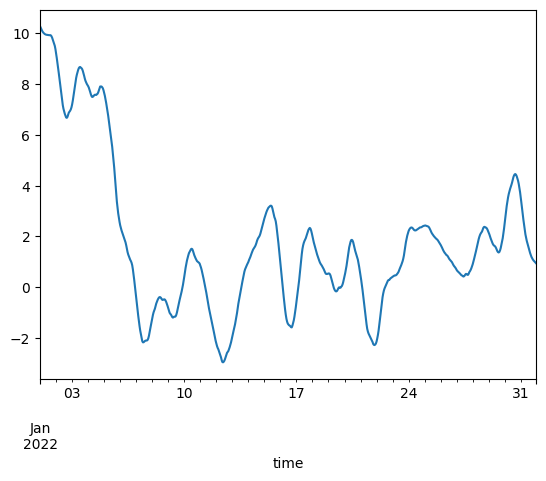

In [4]:
best_model_data.rolling("1D")["temperature_2m"].mean().loc["2022-01"].plot()

<Axes: xlabel='time'>

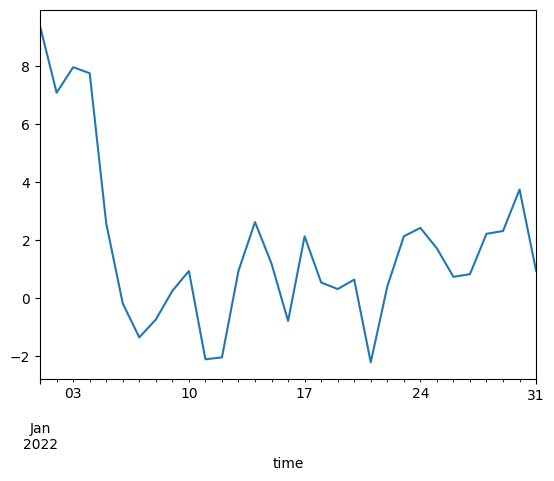

In [5]:
# Compare it to the "normal" resample window

best_model_data.resample("1D")["temperature_2m"].mean().loc["2022-01"].plot()

In [6]:
# What was the lowest and highest temperature in the previous year?

# best_model_data.rolling("365D").agg(["min", "max"]).plot()

**Warning** Long rolling windows over long indices can take forever! In our case, we can luckily operate on daily data, combining the resampling with rolling windows.

In [7]:
mean_daily_temperature = best_model_data.resample("1D")["temperature_2m"].mean()
mean_daily_temperature.rolling("365D").mean()

time
2000-01-01 00:00:00+01:00    -1.047826
2000-01-02 00:00:00+01:00    -0.267663
2000-01-03 00:00:00+01:00    -0.290942
2000-01-04 00:00:00+01:00     0.169293
2000-01-05 00:00:00+01:00     0.652935
                               ...    
2022-12-27 00:00:00+01:00    10.043447
2022-12-28 00:00:00+01:00    10.052169
2022-12-29 00:00:00+01:00    10.061587
2022-12-30 00:00:00+01:00    10.055217
2022-12-31 00:00:00+01:00    10.049132
Freq: D, Name: temperature_2m, Length: 8401, dtype: float64

**Exercise** Find the 24 interval with the highest difference between the min and maximum temperature.

In [8]:
class TemperatureModel(DataFrameModel):
    temperature_2m: float = pa.Field(nullable=True)


@pa.check_types
def find_24h_max_temp_diff(df: DataFrame[TemperatureModel]) -> pd.Timestamp:
    min_and_max = df.rolling("24H", min_periods=24)["temperature_2m"].agg(["min", "max"]).dropna()
    amplitude = min_and_max["max"] - min_and_max["min"]
    return amplitude.idxmax()

max_diff = find_24h_max_temp_diff(best_model_data)
max_diff


Timestamp('2021-02-16 06:00:00+0100', tz='Europe/Prague')

<Axes: xlabel='time'>

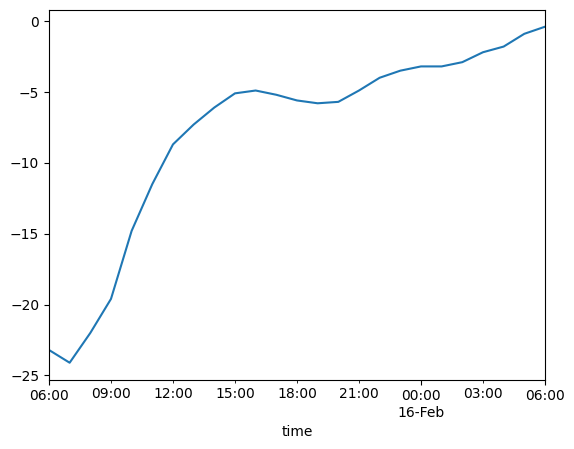

In [9]:
best_model_data.loc[max_diff - pd.Timedelta(hours=24):max_diff, "temperature_2m"].plot()

## Differences, lagged features

When you want to see how something changed, you can use one of the two functions:
- **shift** creates a series that is shifted vertically (by a number of rows or by a time interval)
- **diff** does the shifting and then combines it with 

In [10]:
pd.DataFrame({
    "temp": mean_daily_temperature,
    "temp_1d_ago": mean_daily_temperature.shift(1)
})

,temp,temp_1d_ago
time,,
2000-01-01 00:00:00+01:00,-1.047826,NaN
2000-01-02 00:00:00+01:00,0.512500,-1.047826
2000-01-03 00:00:00+01:00,-0.337500,0.512500
2000-01-04 00:00:00+01:00,1.550000,-0.337500
2000-01-05 00:00:00+01:00,2.587500,1.550000
...,...,...
2022-12-27 00:00:00+01:00,3.216667,8.212500
2022-12-28 00:00:00+01:00,2.850000,3.216667
2022-12-29 00:00:00+01:00,7.541667,2.850000


In [11]:
mean_daily_temperature.shift(freq="1D")

time
2000-01-02 00:00:00+01:00   -1.047826
2000-01-03 00:00:00+01:00    0.512500
2000-01-04 00:00:00+01:00   -0.337500
2000-01-05 00:00:00+01:00    1.550000
2000-01-06 00:00:00+01:00    2.587500
                               ...   
2022-12-28 00:00:00+01:00    3.216667
2022-12-29 00:00:00+01:00    2.850000
2022-12-30 00:00:00+01:00    7.541667
2022-12-31 00:00:00+01:00    5.904167
2023-01-01 00:00:00+01:00    8.100000
Freq: D, Name: temperature_2m, Length: 8401, dtype: float64

In [12]:
mean_daily_temperature.diff(1)

time
2000-01-01 00:00:00+01:00         NaN
2000-01-02 00:00:00+01:00    1.560326
2000-01-03 00:00:00+01:00   -0.850000
2000-01-04 00:00:00+01:00    1.887500
2000-01-05 00:00:00+01:00    1.037500
                               ...   
2022-12-27 00:00:00+01:00   -4.995833
2022-12-28 00:00:00+01:00   -0.366667
2022-12-29 00:00:00+01:00    4.691667
2022-12-30 00:00:00+01:00   -1.637500
2022-12-31 00:00:00+01:00    2.195833
Freq: D, Name: temperature_2m, Length: 8401, dtype: float64

**Exercise:** Find the day (and hour) when the temperature dropped the most in 24 hours and plot several interesting quantities (pressure, wind, rain, ...) alongside with it. What is the conceptual difference with respect to the last exercise?

In [13]:
def find_extreme_drop(df: DataFrame):
    temperature_24h_ago = df["temperature_2m"].shift(freq="24H")
    difference = df["temperature_2m"] - temperature_24h_ago
    return difference.idxmin()

extreme_drop_in_24h = find_extreme_drop(best_model_data)

extreme_drop_in_24h

Timestamp('2015-04-28 16:00:00+0200', tz='Europe/Prague')

<Axes: xlabel='time'>

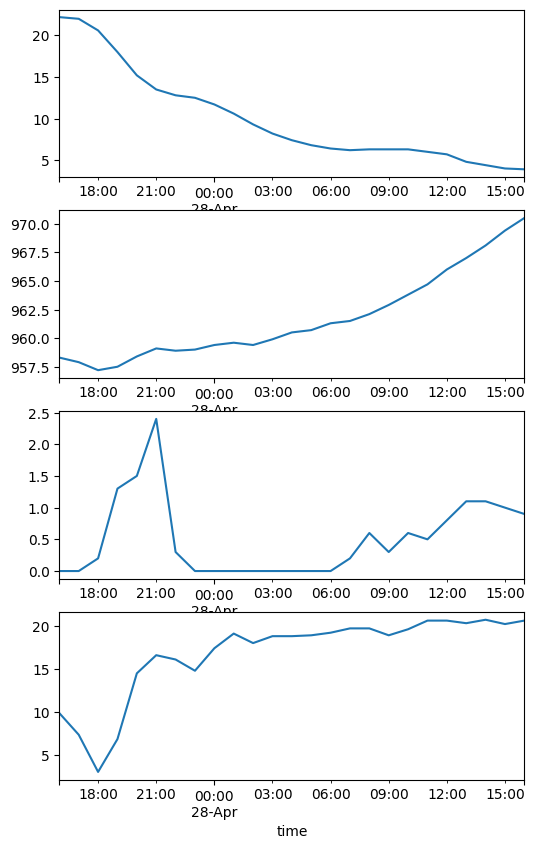

In [26]:
extreme_drop_day_date = best_model_data[extreme_drop_in_24h - pd.Timedelta(hours=24):extreme_drop_in_24h]

fig, ax = plt.subplots(4, figsize=(6, 10))
extreme_drop_day_date["temperature_2m"].plot(ax=ax[0])
extreme_drop_day_date["surface_pressure"].plot(ax=ax[1])
extreme_drop_day_date["rain"].plot(ax=ax[2])
extreme_drop_day_date["windspeed_10m"].plot(ax=ax[3])

### Complex exercise: Write our own Trend/Seasonality/Error decomposition

With long-term evolution of some quantity (temperature is a very nice example!) that shows periodic behaviour, it is useful to split it into three parts: the trend, the seasonality and the rest ("error"). There is a bit of alchemy in finding the appropriate mechanism for that as the split is usually somewhat artifical but we will not be bothered that much about it.

One particular approach is to model the time-series using a model from `statsmodels`.

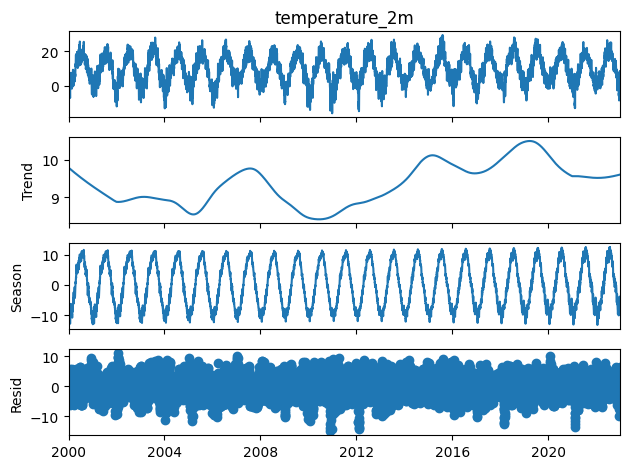

In [16]:
from statsmodels.tsa.seasonal import STL

stl_model = STL(mean_daily_temperature, period=365, trend=4*365 + 1, seasonal=181)
decomposed = stl_model.fit()
decomposed.plot();

**Exercise:** Extract the trend and seasonality from the daily temperature means using the rolling windows (we will skip the daily seasonality as it would be a bit overcomplex).

Suggested approach (not the only and right one!): 
- Take the trend as a mean over a sufficiently long rolling window
- Take the seasonality as a mean over a shorter-period rolling window (other, more correct, approach would be to find a mean for each day of the year over multiple years - you are free to do that!) of what remains from the data
- Take the error as what is left if you subtract the previous two.

Hints. the `win_type` argument can give more weights to the observed values than the default constant one (e.g. "triang")

In [20]:
def decompose(series: pd.Series) -> pd.DataFrame:
    trend = series.rolling(730, center=True, win_type="triang").mean()
    seasonality = (series - trend).rolling(30, center=True, win_type="triang").mean()
    error = (series - trend - seasonality)
    return pd.DataFrame({
        "trend": trend,
        "seasonality": seasonality,
        "error": error
    })


In [21]:
tse = decompose(mean_daily_temperature)

<Axes: xlabel='time'>

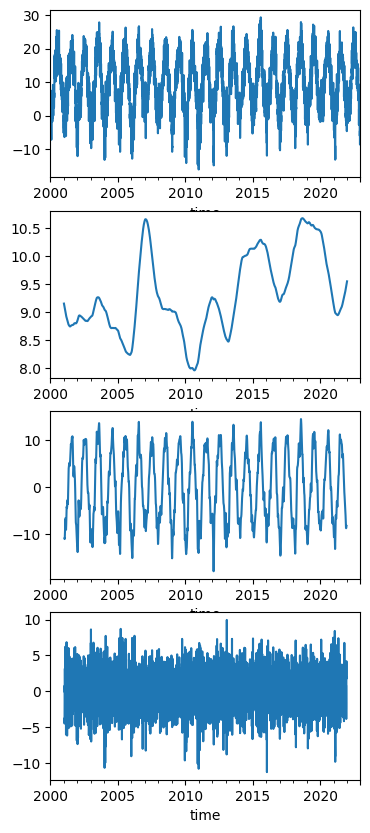

In [22]:
fig, ax = plt.subplots(4, 1, figsize=(4, 10))

mean_daily_temperature.plot(ax=ax[0])
tse["trend"].plot(ax=ax[1])
tse["seasonality"].plot(ax=ax[2])
tse["error"].plot(ax=ax[3])

In [23]:
# Let's try to apply this on CHMI data as well.
chmi_data = load_chmi_data()

In [24]:
chmi_tse = decompose(chmi_data["average_temperature"])

<Axes: xlabel='date'>

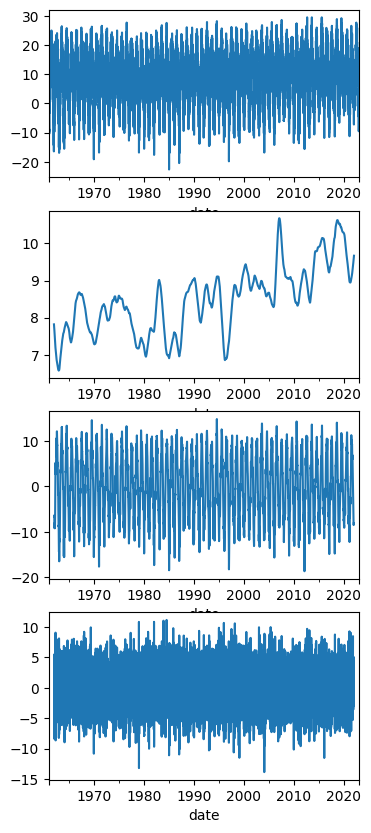

In [25]:
fig, ax = plt.subplots(4, 1, figsize=(4, 10))

chmi_data["average_temperature"].plot(ax=ax[0])
chmi_tse["trend"].plot(ax=ax[1])
chmi_tse["seasonality"].plot(ax=ax[2])
chmi_tse["error"].plot(ax=ax[3])